In [1]:
# Importanweisungen
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.axes as axes
from matplotlib import colors as mcolors
import matplotlib.patches as mpatches
import itertools
import math
import numpy as np
import statistics as stat
import scipy as sci
from scipy import optimize
from scipy.interpolate import CubicSpline
from scipy.odr import *
import uncertainties as unc
import uncertainties.unumpy as unp
import uncertainties.umath as umath
import pandas as pd

unv=unp.nominal_values
usd=unp.std_devs

In [2]:
# Konstanten fuer einheitliche Darstellung
sidescreen = (8, 6)
fullscreen = (10,6)
widescreen = (16,6)
flatscreen = (10,4)
fig_size = fullscreen
fig_legendsize = 14
fig_labelsize = 12
matplotlib.rcParams.update({'font.size': fig_labelsize})

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

root = "../"
data_out = "dat/"
raw_in = "raw/"

In [3]:
# allgemeine Fitfunktionen
class Fit:
    def const(x,c):
        return c

    def linear(x,m):
        return(m*x)

    def gerade(x, m, b):
        return (m*x + b)

    def gerade0(x0):
        return lambda x, m, b: m * (x-x0) + b

    def cyclic(x, a, f, phi):
        return a * np.sin(x * f - phi)

    def cyclicOff(x, a, f, phi, offset):
        return cyclic(x, a, f, phi) + offset

    def gaussOff(x, x0, A, d, y0):
        return A * unp.exp(-(x - x0)**2 / 2 / d**2) + y0

    def gauss(x, A, x0, d):
        return A * unp.exp(-(x-x0)**2 / 2 / d**2)

    def exponential(x, c, y0):
        return unp.exp(c * x) * y0

    def uncertain(array): # True, if ALL datapoints have uncertainties
        k = usd(array) == 0
        for i in k:
            if i:
                return False
        return True

    # fittet ein dataset mit gegebenen x und y werten, eine funktion und ggf. anfangswerten und y-Fehler
    # gibt die passenden parameter der funktion mit unsicherheiten zurueck
    def fitY(datax, datay, function, p0=None, **kwargs):
        if yerr is None:
            yerr = usd(datay)
        pfit, pcov = optimize.curve_fit(function, unv(datax), unv(datay), p0=p0, sigma=usd(datay), epsfcn=0.0001, maxfev=10000, **kwargs)
        perr = np.sqrt(np.diag(pcov))
        return unp.uarray(pfit, perr)

    def fitXY(datax, datay, function, p0, **kwargs):
        model = Model(lambda p,x : function(x,*p))
        realdata = RealData(unv(datax),unv(datay),sx=usd(datax),sy=usd(datay))
        odr = ODR(realdata,model,beta0=p0, **kwargs)
        out = odr.run()
        return unp.uarray(out.beta,out.sd_beta)

    def fitspaceY(datax, datay, function, p0=None, xfit=None, range=None, **kwargs):
        if range is None:
            range = min(unv(datax)), max(unv(datax))
        if xfit is None:
            xfit = np.linspace(*range, **kwargs)
        p = Fit.fitX(datax, datay, function, p0=p0, **kwargs)
        return xfit, function(xfit, *p)

    def fitspaceXY(datax, datay, function, p0, xfit=None, range=None, **kwargs):
        if range is None:
            range = min(unv(datax)), max(unv(datax))
        if xfit is None:
            xfit = np.linspace(*range, **kwargs)
        p = Fit.fitXY(datax, datay, function, p0=p0, **kwargs)
        return xfit, function(xfit, *p)

    def interpolate(x, y):
        return CubicSpline(x, y)

    def interpolatespace(x, y, range=None, **kwargs):
        if range is None:
            range = min(unv(datax)), max(unv(datax))
        xfit = np.linspace(*range, **kwargs)
        return interpolate(xfit)

In [17]:
# gibt Daten fuer LaTeX bereitgestellt aus
class Latex:
    def value(val, file):
        s = str(val)
        s = s.replace('+/-', ' \\pm ') # plus minus with latex notation
        s = s.replace('.', ',') # german comma
        s = s.replace('(', '') # german comma
        s = s.replace(')', '') # german comma
        with open(root + data_out + '%s.txt' % file, 'w') as f:
            f.write(s)

    def SI(val, unit, file):
        Latex.value("\\SI{%s}{%s}" % (val, unit), file)

    def table(df, file, header=None, text=[]):
        if header is None:
            header = ["c"]*len(df.colums)
        text = [False if i in text else False for i in range(len(df.colums))]
        with open(root + data_out + '%s.txt' % file, 'w') as f:
            f.write("\\begin{tabular}{" + " | ".join(header) + "} \\toprule \n")
            f.write(" & ".join(df.keys())+"\\\\ \\midrule")
            for i, row in df.iterrows():
                k = "\n" + " & ".join(["$%s$" % str(x) if b else str(x) for x,b in zip(row.values, text)]) + " \\\\"
                k = k.replace("+/-"," \\pm ").replace(".",",").replace("$$","")
                f.write(k)
            f.write("\\bottomrule\n\\end{tabular}")

In [18]:
# Konstanten; Werte von https://physics.nist.gov/cuu/Constants/index.html[0]
c0 = 299792458 # m/s
k_B = unc.ufloat_fromstr("1.38064852(79)e-23") # J K-1 [0]
h = unc.ufloat_fromstr("4.135667662(25)e-15") # eV s [0]
barn = 1E-28 # m2
K = 273.15 # kelvin
eV = unc.ufloat_fromstr("1.602176634e-19") # J
g = 9.81 # m/s^2
rad = 360 / 2 / math.pi
grad = 1/rad
terra = 1e12
giga = 1e9
mega = 1e6
kilo = 1e3
dezi = 0.1
centi = 0.01
milli = 1e-3
micro = 1e-6
nano = 1e-9
pico = 1e-12
femto = 1e-15

In [19]:
# %% import der Messwerte
def countsFold(*paths, N=256):
    total = unp.uarray([0]*N,0)
    for p in paths:
        counts = np.loadtxt(root + raw_in + p, delimiter = " ", usecols = [1])
        u = np.sqrt(counts + 1)
        k = unp.uarray(counts, u)
        increase = k[:N] + k[-1:N-1:-1]
        total += increase
    return unp.uarray(range(N), 1), total

messungA = countsFold("messungA1.txt")
messungB = countsFold("messungB2.txt", "messungB3.txt")
messungC = countsFold("messungC1.txt", "messungC2.txt")
messungVel0 = countsFold("velocity0_ohne_probe_smoothed.txt")
messungVel1 = countsFold("velocity1_smoothed.txt")
messungVel2 = countsFold("velocity2_smoothed.txt")
messungVel3 = countsFold("velocity3_smoothed.txt")
messungVelM0 = countsFold("velocity0_ohne_probe.txt")
messungVelM1 = countsFold("velocity1.txt")
messungVelM2 = countsFold("velocity2.txt")
messungVelM3 = countsFold("velocity3.txt")

A = (2.078+/-0.016)e+04, Phi = 0.3+/-0.8


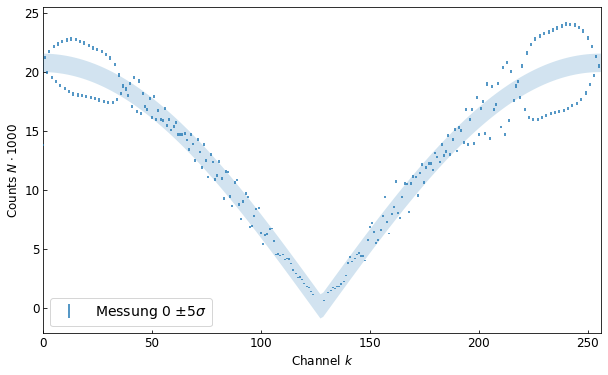

A = (2.141+/-0.025)e+04, Phi = -1.1+/-1.2


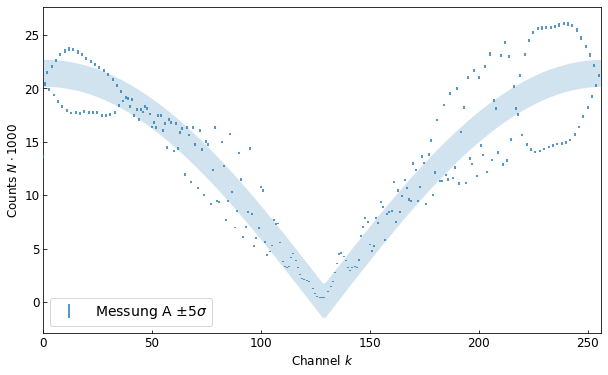

A = (5.721+/-0.030)e+04, Phi = 0.4+/-0.7


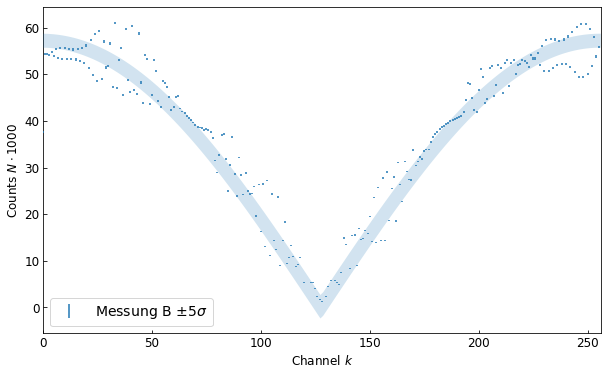

A = (2.114+/-0.011)e+04, Phi = 0.7+/-0.6


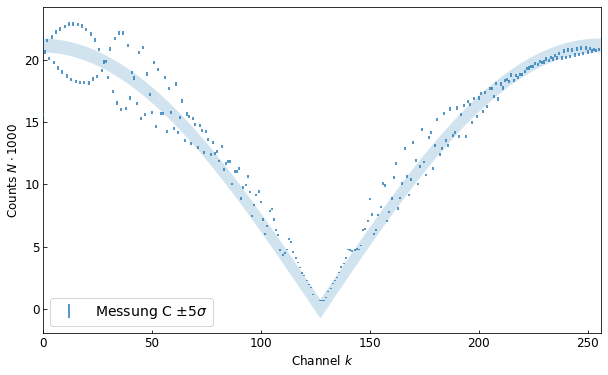

In [20]:
# %% Diagramme velocity vergleich

def speedFit(x, A, phi):
    return A * np.abs(np.cos(math.pi/256 * (x + phi)))

def speedUnc(x, A, phi):
    return A * np.abs(unp.cos(math.pi/256 * (x + phi)))

def speedCalc(A, phi, lamb, nu, Nk, M):
    return lambda x: A * unp.cos(math.pi/Nk * (x + phi)) * lamb * nu * Nk / 2 / M

speed = []
for col, i, (c,n), (k,l) in zip(colors, "0ABC", [messungVel0, messungVel1, messungVel2, messungVel3], [messungVelM0, messungVelM1, messungVelM2, messungVelM3]):
    fig, ax = plt.subplots(figsize=fullscreen)
    color = colors[col]
    m = max(n)
    p = Fit.fitXY(k,l,speedFit, p0=[20533, 0])
    print("A = %s, Phi = %s" % (p[0], p[1]))
    speed.append(speedCalc(*p, unc.ufloat(635,5) * nano, 24, 256, 20000))
    Latex.value(p[1], "velocity_x0_%s" % i)
    Latex.value(p[0], "velocity_A_%s" % i)
    xfit = np.linspace(0,256,200)
    yfit = speedUnc(xfit, *p) / 1000
    l1 = l / 1000
    #plt.plot(unv(xfit), unv(yfit), label="fit", color=color, alpha=0.5)
    #plt.axvline(x=unv(p[1]), zorder=15)
    kappa = 5
    plt.fill_between(unv(xfit), unv(yfit) - kappa*usd(yfit), unv(yfit) + kappa*usd(yfit), alpha=0.2, zorder=5)
    plt.errorbar(unv(k), unv(l1), usd(l1), label = "Messung %s $\\pm %s \\sigma$" % (i, kappa), fmt=" ", zorder=10)

    plt.xlabel("Channel $k$")
    plt.ylabel(u"Counts $N \\cdot 1000$")
    plt.xlim(0, 256)
    #plt.ylim(0, 2000)
    plt.legend(prop={'size':fig_legendsize}, loc='lower left')
    plt.tick_params(labelsize=fig_labelsize, direction="in")
    #plt.xscale('log')
    #plt.yscale('log', nonposy='clip')
    plt.savefig(root + data_out + "velocity%s.png" % i)
    plt.savefig(root + data_out + "velocity%s.pdf" % i)
    plt.show()
    plt.close()

[0.0+/-1.0 1.0+/-1.0 2.0+/-1.0 3.0+/-1.0 4.0+/-1.0 5.0+/-1.0 6.0+/-1.0
 7.0+/-1.0 8.0+/-1.0 9.0+/-1.0]
[0.002088518675218243+/-2.9670421817056577e-05
 0.002088694355828536+/-2.9668217338218028e-05
 0.002088555486751663+/-2.9669959926780063e-05
 0.0020881020889007952+/-2.967564783797538e-05
 0.002087334230555983+/-2.968527537920278e-05
 0.0020862520273538672+/-2.9698832923422646e-05
 0.00208485564227027+/-2.9716306931760513e-05
 0.0020831452855956485+/-2.9737679985188494e-05
 0.0020811212149034275+/-2.9762930825103218e-05
 0.0020787837350112067+/-2.9792034402569408e-05]
-0.270+/-0.016


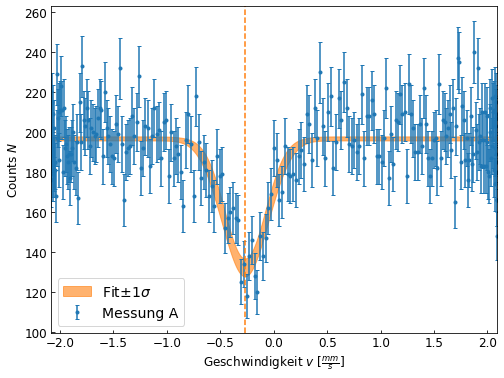

In [21]:
# %% Diagramm messung A

def gauss(x, A, x1, d, y0):
    return A * np.exp(-(x-x1)**2 / 2 / d**2) + y0

def gaussUnc(x, A, x1, d, y0):
    return A * unp.exp(-(x-x1)**2 / 2 / d**2) + y0

s = 1
x, y = messungA
print(x[:10])
x = speed[s](x)
print(x[:10])
p0 = [-100, -0.00025, 0.001, 200]
p = Fit.fitXY(x,y,gauss, p0=p0)
#Latex.value(p[1], "velocity_x0_%i" % i)
#Latex.value(p[0], "velocity_A_%i" % i)
isoA = p[1]
isoA = unp.uarray(-0.2697331989177993, 0.016452298067780063)*milli
print(isoA / milli)
Latex.SI(isoA / milli, "\\milli\\meter\\per\\second", "messungA_iso")

xfit = np.linspace(min(x), max(x), 2000)
yfit = gaussUnc(xfit, *p)
isoA = unp.uarray(-0.2697331989177993, 0.016452298067780063)*milli
yfit_jannik = gaussUnc(xfit, p[0], isoA, p[2], p[3])
x = x / milli
xfit = xfit / milli

fig, ax = plt.subplots(figsize=sidescreen)
#plt.plot(unv(xfit), unv(yfit), label="Doppelgauss-Fit", alpha=0.5)
#plt.axvline(x=unv(p[1]))
kappa = 1
plt.fill_between(unv(xfit), unv(yfit_jannik) - kappa*usd(yfit_jannik), unv(yfit_jannik) + kappa*usd(yfit_jannik), alpha=0.6, label="Fit$\\pm %s \\sigma$" % kappa, color="C1")
#plt.plot(unv(xfit), unv(yfit_jannik), color="C3")
plt.errorbar(unv(x), unv(y), usd(y), label = "Messung A", color="C0", fmt=".C0", capsize=2.)
plt.axvline(x=unv(isoA / milli), color="C1", linestyle="--")
#plt.annotate("$v_{iso} = %s$" % iso, xy=(unv(isoB), unv(gauss2Unc(iso,*p))))

#plt.grid()
plt.xlabel(r"Geschwindigkeit $v$ [$\frac{mm}{s}$]")
plt.ylabel(u"Counts $N$")
plt.xlim(unv(min(x)), unv(max(x)))
#plt.ylim(195, 455)
plt.legend(prop={'size':fig_legendsize})
plt.tick_params(labelsize=fig_labelsize, direction="in")
#plt.xscale('log')
#plt.yscale('log', nonposy='clip')
plt.savefig(root + data_out + "messungA.png")
plt.savefig(root + data_out + "messungA.pdf")
plt.show()
plt.close()

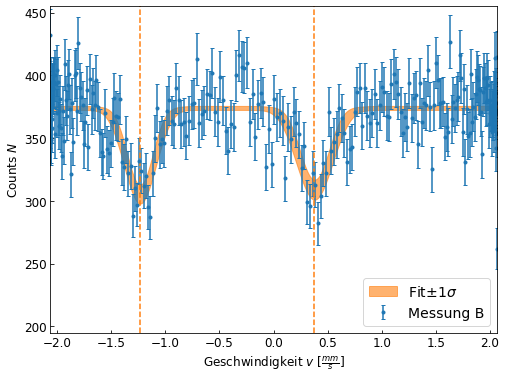

In [32]:
# %% Diagramm messung B

def gauss2(x, A1, x1, d1, A2, x2, d2, y0):
    return A1 * np.exp(-(x-x1)**2 / 2 / d1**2) + A2 * np.exp(-(x-x2)**2 / 2 / d2**2) + y0

def gauss2Unc(x, A1, x1, d1, A2, x2, d2, y0):
    return A1 * unp.exp(-(x-x1)**2 / 2 / d1**2) + A2 * unp.exp(-(x-x2)**2 / 2 / d2**2) + y0

s = 3
x, y = messungB
x = speed[s](x)
p0 = [-100, 0.0005, 0.0002, -100, -0.0012, 0.0002, 380]
p = Fit.fitXY(x,y,gauss2, p0=p0)
#Latex.value(p[1], "velocity_x0_%i" % i)
#Latex.value(p[0], "velocity_A_%i" % i)
A1, x1, d1, A2, x2, d2, y0 = p
isoB = (x1 + x2) / 2
dvB = x2 - x1
VB = np.array([x1, x2]) - isoB
Latex.SI(isoB / milli, "\\milli\\meter\\per\\second", "messungB_iso")
Latex.SI(dvB / milli, "\\milli\\meter\\per\\second", "messungB_dv")
for i,(v,xt) in enumerate(zip(VB,[x1,x2])):
    Latex.SI(v / milli, "\\milli\\meter\\per\\second", "messungB_v_%i"%i)
    dE = E * v / c0 * giga
    Latex.SI(dE, "\\electronvolt", "messungB_E_%i"%i)
    Latex.SI(xt / milli, "\\milli\\meter\\per\\second", "messungB_x_%i"%i)

xfit = np.linspace(min(unv(x)),max(unv(x)),2000)
yfit = gauss2Unc(xfit, *p)
x = x / milli
xfit = xfit / milli

fig, ax = plt.subplots(figsize=sidescreen)
#plt.plot(unv(xfit), unv(yfit), label="Doppelgauss-Fit", alpha=0.5)
#plt.axvline(x=unv(p[1]))
kappa = 1
plt.fill_between(unv(xfit), unv(yfit) - kappa*usd(yfit), unv(yfit) + kappa*usd(yfit), alpha=0.6, label="Fit$\\pm %s \\sigma$" % kappa, color="C1")
plt.errorbar(unv(x), unv(y), usd(y), label = "Messung B", color="C0", fmt=".C0", capsize=2)
plt.axvline(x=unv(x1 / milli), color="C1", linestyle="--")
plt.axvline(x=unv(x2 / milli), color="C1", linestyle="--")
#plt.annotate("$v_{iso} = %s$" % iso, xy=(unv(isoB), unv(gauss2Unc(iso,*p))))

#plt.grid()
plt.xlabel(r"Geschwindigkeit $v$ [$\frac{mm}{s}$]")
plt.ylabel(u"Counts $N$")
plt.xlim(unv(min(x)), unv(max(x)))
plt.ylim(195, 455)
plt.legend(prop={'size':fig_legendsize})
plt.tick_params(labelsize=fig_labelsize, direction="in")
#plt.xscale('log')
#plt.yscale('log', nonposy='clip')
plt.savefig(root + data_out + "messungB.png")
plt.savefig(root + data_out + "messungB.pdf")
plt.show()
plt.close()

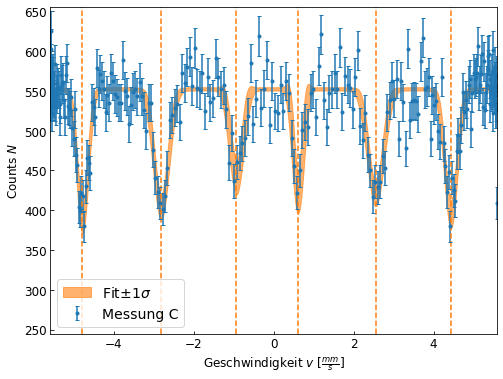

In [33]:
# %% Diagramm messung C

def gauss6(x, A1, x1, d1, A2, x2, d2, A3, x3, d3, A4, x4, d4, A5, x5, d5, A6, x6, d6, y0):
    return A1 * np.exp(-(x-x1)**2 / 2 / d1**2) + A2 * np.exp(-(x-x2)**2 / 2 / d2**2) + \
        A3 * np.exp(-(x-x3)**2 / 2 / d3**2) + A4 * np.exp(-(x-x4)**2 / 2 / d4**2) +\
        A5 * np.exp(-(x-x5)**2 / 2 / d5**2) + A6 * np.exp(-(x-x6)**2 / 2 / d6**2) + y0

def gauss6Unc(x, A1, x1, d1, A2, x2, d2, A3, x3, d3, A4, x4, d4, A5, x5, d5, A6, x6, d6, y0):
    return A1 * unp.exp(-(x-x1)**2 / 2 / d1**2) + A2 * unp.exp(-(x-x2)**2 / 2 / d2**2) + \
        A3 * unp.exp(-(x-x3)**2 / 2 / d3**2) + A4 * unp.exp(-(x-x4)**2 / 2 / d4**2) +\
        A5 * unp.exp(-(x-x5)**2 / 2 / d5**2) + A6 * unp.exp(-(x-x6)**2 / 2 / d6**2) + y0

s = 2
x, y = messungC
x = speed[s](x)
p0 = [-150, 0.0043, 0.0003,-150, 0.0026, 0.0003, -150, 0.0007, 0.0003, -150, -0.001, 0.0003, -150, -0.003, 0.0003, -150, -0.005, 0.0003, 550]
p = Fit.fitXY(x,y,gauss6, p0=p0)
#Latex.value(p[1], "velocity_x0_%i" % i)
#Latex.value(p[0], "velocity_A_%i" % i)
x0 = np.array([p[i] for i in [1,4,7,10,13,16]])
isoC = sum(x0) / len(x0)
VC = x0 - isoC
for i,(v,xt) in enumerate(zip(VC,x0)):
    Latex.SI(v / milli, "\\milli\\meter\\per\\second", "messungC_v_%i" % i)
    Latex.SI(xt / milli, "\\milli\\meter\\per\\second", "messungC_x_%i" % i)
    dE = E * v / c0 * giga
    Latex.SI(dE / milli, "\\electronvolt", "messungC_E_%i" % i)
Latex.SI(isoC / milli, "\\milli\\meter\\per\\second", "messungC_iso")

xfit = np.linspace(min(unv(x)),max(unv(x)),2000)
yfit = gauss6Unc(xfit, *p)
x = x / milli
xfit = xfit / milli

fig, ax = plt.subplots(figsize=sidescreen)
#plt.plot(unv(xfit), unv(yfit), label="Doppelgauss-Fit", alpha=0.5)
for v in x0:
    plt.axvline(x=unv(v / milli), color="C1", linestyle="--")
kappa = 1
plt.fill_between(unv(xfit), unv(yfit) - kappa*usd(yfit), unv(yfit) + kappa*usd(yfit), alpha=0.6, label="Fit$\\pm %s \\sigma$" % kappa, color="C1")
plt.errorbar(unv(x), unv(y), usd(y), label = "Messung C", color="C0", fmt=".C0", capsize=2)
#plt.axvline(x=unv(speed[s](x1) / milli), color="C1", linestyle="--")
#plt.axvline(x=unv(speed[s](x2) / milli), color="C1", linestyle="--")
#plt.annotate("$v_{iso} = %s$" % iso, xy=(unv(iso), unv(gauss2Unc(iso,*p))))

#plt.grid()
plt.xlabel(r"Geschwindigkeit $v$ [$\frac{mm}{s}$]")
plt.ylabel(u"Counts $N$")
plt.xlim(unv(min(x)), unv(max(x)))
plt.ylim(245, 655)
plt.legend(prop={'size':fig_legendsize})
plt.tick_params(labelsize=fig_labelsize, direction="in")
#plt.xscale('log')
#plt.yscale('log', nonposy='clip')
plt.savefig(root + data_out + "messungC.png")
plt.savefig(root + data_out + "messungC.pdf")
plt.show()
plt.close()

Na_2Fe(CN)_5NO \cdot 2H_2O -0.4374+/-0.0018
Cr -0.3258+/-0.0032
Edelstahl -0.2658+/-0.0032
Na_4Fe(CN)_6 \cdot 10H_2O -0.2351+/-0.0024
K_4Fe(CN)_6 \cdot 3H_2O -0.2218+/-0.0032
\alpha-Fe -0.1798+/-0.0018
Rh -0.0589+/-0.0025
Pd 0.0+/-0
Cu 0.0444+/-0.0016
Pt 0.1686+/-0.0027
\alpha-Fe_2O_3 0.1852+/-0.0032
Testing v = -0.270+/-0.016
0.17	Na_2Fe(CN)_5NO \cdot 2H_2O
0.06	Cr
0.00	Edelstahl
0.03	Na_4Fe(CN)_6 \cdot 10H_2O
0.05	K_4Fe(CN)_6 \cdot 3H_2O
0.09	\alpha-Fe
0.21	Rh
0.27	Pd
0.31	Cu
0.44	Pt
0.45	\alpha-Fe_2O_3
Testing v = -0.428+/-0.014
0.01	Na_2Fe(CN)_5NO \cdot 2H_2O
0.10	Cr
0.16	Edelstahl
0.19	Na_4Fe(CN)_6 \cdot 10H_2O
0.21	K_4Fe(CN)_6 \cdot 3H_2O
0.25	\alpha-Fe
0.37	Rh
0.43	Pd
0.47	Cu
0.60	Pt
0.61	\alpha-Fe_2O_3
Testing v = -0.154+/-0.013
0.28	Na_2Fe(CN)_5NO \cdot 2H_2O
0.17	Cr
0.11	Edelstahl
0.08	Na_4Fe(CN)_6 \cdot 10H_2O
0.07	K_4Fe(CN)_6 \cdot 3H_2O
0.03	\alpha-Fe
0.09	Rh
0.15	Pd
0.20	Cu
0.32	Pt
0.34	\alpha-Fe_2O_3


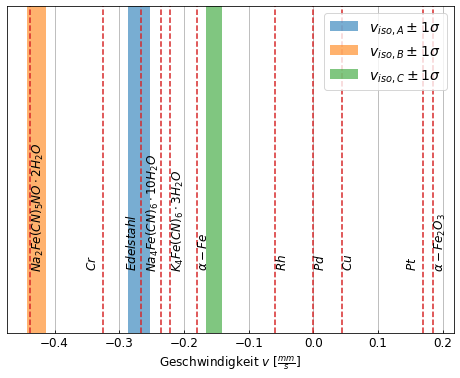

In [24]:
# %% abgleich der isomerieverschiebungen in der tabelle
iso = unp.uarray([-0.2576, -0.146, -0.086, -0.0553, -0.042, 0, 0.1209, 0.1798, 0.2242, 0.3484, 0.365], [0.0014,0.003,0.003,0.0021,0.003,0.0014,0.0022,0.0012,0.0010,0.0024,0.003])
iso -= iso[7]
names = ["Na_2Fe(CN)_5NO \\cdot 2H_2O", "Cr", "Edelstahl", "Na_4Fe(CN)_6 \\cdot 10H_2O", "K_4Fe(CN)_6 \\cdot 3H_2O","\\alpha-Fe", "Rh", "Pd", "Cu", "Pt", "\\alpha-Fe_2O_3"]
offset = np.array([0,1,1,1,0,0,0,0,0,1,0]) * -0.025

fig, ax = plt.subplots(figsize=sidescreen)
#plt.plot(unv(xfit), unv(yfit), label="Doppelgauss-Fit", alpha=0.5)
kappa = 1
for v, n, o in zip(iso,names,offset):
    plt.axvline(x=unv(v), color="C3", linestyle="--")
    #plt.fill_betweenx([0,1], [unv(v) - kappa*usd(v)]*2, [unv(v) + kappa*usd(v)]*2, alpha=0.6)
    plt.annotate("$%s$"%n, (unv(v)+o, 0.2), rotation=90)

for v,k in zip([isoA, isoB, isoC], "ABC"):
    v /= milli
    plt.fill_betweenx([0,1], [unv(v) - kappa*usd(v)]*2, [unv(v) + kappa*usd(v)]*2, alpha=0.6, label="$v_{iso,%s}\\pm %s \\sigma$" % (k,kappa))

def vglISO(im):
    print("Testing v = %s" % im)
    for n, i in zip(names, np.abs(im-iso)):
        print("%.2f\t%s" % (unv(i),n))

for i,n in zip(iso,names):
    print(n, i)
vglISO(isoA/milli)
vglISO(isoB/milli)
vglISO(isoC/milli)

plt.grid()
plt.xlabel(r"Geschwindigkeit $v$ [$\frac{mm}{s}$]")
#plt.ylabel(u"Counts $N$")
#plt.xlim(unv(min(x)), unv(max(x)))
plt.ylim(0, 1)
plt.legend(prop={'size':fig_legendsize}, loc='upper right')
plt.tick_params(labelsize=fig_labelsize, direction="in")
plt.yticks([])
#plt.xscale('log')
#plt.yscale('log', nonposy='clip')
plt.savefig(root + data_out + "isoVgl.png")
plt.savefig(root + data_out + "isoVgl.pdf")
plt.show()
plt.close()

In [25]:
# %% aufgabe 4 + 5

iso1, iso2, iso3 = iso[2], iso[0], iso[5]

S26 = 1.33
Z = 26
A = 57
e = 1
E = unc.ufloat(14.41295,0.00031) / mega # GeV
e0 = 55.26349406 # e2 GeV-1 fm-1
R = 1.3 * A**(1/3) # fm
a0 = 0.0529177210903 * nano # meter

PA_Pd = unc.ufloat(11881.8, 0.1) # a0-3
PA_ss = unc.ufloat(11882.4, 0.1) # a0-3
PA_KFe = unc.ufloat(11882.3, 0.1) # a0-3

dRR = abs(isoA) * 5 * E * e0 / (S26 * c0 * e**2 * Z * R**2 * (PA_ss - PA_Pd)) * (a0 / femto)**3 # a03 fm-3
print(dRR)
#dRR = unc.ufloat(0.0010213997786670539, 6.229998262140531e-05)
PA_A = isoA * 5 * E * e0 / (S26 * c0 * e**2 * Z * R**2 * dRR) * (a0 / femto)**3 + PA_Pd # a03 = s m-1 fm-2
PA_B = isoB * 5 * E * e0 / (S26 * c0 * e**2 * Z * R**2 * dRR) * (a0 / femto)**3 + PA_Pd # a03 = s m-1 fm-2
PA_C = isoC * 5 * E * e0 / (S26 * c0 * e**2 * Z * R**2 * dRR) * (a0 / femto)**3 + PA_Pd # a03

print(PA_A)
print(PA_B)
print(PA_C)
Latex.SI(PA_B, "a_0^{-3}", "electrondensity_B")
Latex.SI(PA_C, "a_0^{-3}", "electrondensity_C")

0.00102+/-0.00025
11881.20+/-0.22
11880.85+/-0.31
11881.46+/-0.17


In [26]:
# %% aufgabe 6
print(dvB) # m s-1
Q = unc.ufloat(0.082, 0.008) # b
e = 1
dE = E * (dvB) / c0
Vzz = dE * 2 / (e * Q * barn) * giga # V m-2
print(dE*giga, "eV")
print(Vzz, "V / m2")
Latex.SI(Vzz, "\\volt\\per\\meter\\squared", "Vzz_B")
Latex.SI(dvB/milli, "\\milli\\meter\\per\\second", "Vzz_B_vel")

-0.001612+/-0.000028
(-7.75+/-0.14)e-08 eV
(-1.89+/-0.19)e+22 V / m2


In [42]:
# Aufgabe 7
muN = unc.ufloat(-9.6623647, 0.0000023) * 1e-27 # J T-1
muG = unc.ufloat(0.09044, 0.00007) # muN
v1, v2, v3, v4, v5, v6 = VC
print(E*giga)
k,l = v1, v2
BFeld = - (k + 3 * l) / c0 * E*giga / (2 * muG) * eV / muN # T
print("B_1,2:", BFeld)
Latex.SI(BFeld, "\\tesla", "B_Feld_12")
muA = 3 * muG * (k+l) / (k + 3 * l)
print("mu_1,2:", muA)
Latex.SI(muA, "\\mu_N", "mu_A_12")

k,l = v6,v5
BFeld = - (k + 3 * l) / c0 * E*giga / (2 * muG) * eV / muN # T
print("B_5,6:", BFeld)
Latex.SI(-BFeld, "\\tesla", "B_Feld_56")
muA = 3 * muG * (k+l) / (k + 3 * l)
print("mu_5,6:", muA)
Latex.SI(muA, "\\mu_N", "mu_A_56")

14412.95+/-0.31
B_1,2: 56.0+/-0.4
mu_1,2: 0.1558+/-0.0005
B_5,6: -55.5+/-0.4
mu_5,6: 0.1568+/-0.0005


In [39]:
VC

array([0.004585964519273385+/-2.229624970530991e-05,
       0.002704295064824507+/-2.9881330087774724e-05,
       0.0007647445267310403+/-3.488861267887353e-05,
       -0.0007743370640270008+/-3.389127295536099e-05,
       -0.002657658371815831+/-2.8211073703798366e-05,
       -0.0046230086749861+/-2.0770255544830084e-05], dtype=object)